## Generating small sample of 10k rows with approx 50% positive classes

In [2]:
from kipoi_cadd.data import cadd_train_valid_data, train_test_split_indexes, CaddDataset
from kipoi_cadd.utils import dump_to_pickle, load_pickle
import pandas as pd
from tqdm import tqdm

In [3]:
training_dir = "/s/project/kipoi-cadd/data/raw/v1.3/training_data/"
lmdb_dir = training_dir + "lmdb"
valid_id_file = training_dir + "valid_idx.pkl"
all_ids_file = training_dir + "variant_ids.pkl"

In [4]:
valid_ids = load_pickle(valid_id_file)
len(valid_ids)

7008612

In [5]:
type(valid_ids)

pandas.core.series.Series

### We need to know once and for all how many positive classes there are

In [6]:
full_ds = CaddDataset(lmdb_dir, all_ids_file)

In [ ]:
%%time
pos_classes = []
for ix in tqdm(range(len(full_ds))):
    item = full_ds.__getitem__(ix)
    if item['targets'] == 1:
        pos_classes.append(ix)
print(len(pos_classes))

What if we extract the first 10k rows of the shuffled_index.pickle? It should maintain the ratio of the bigger dataset.

In [7]:
shuffled_ids_file = training_dir + "shuffle_splits/shuffled_index.pickle"
shuffled_ids = load_pickle(shuffled_ids_file)

In [8]:
shuffled_sample = shuffled_ids[:10000]

In [9]:
%%time
count = 0
for ix in tqdm(shuffled_sample):
    item = full_ds.__getitem__(ix)
    if item['targets'] == 1:
        count += 1
print(count)

100%|██████████| 10000/10000 [00:01<00:00, 6475.61it/s]

4925
CPU times: user 1.39 s, sys: 163 ms, total: 1.56 s
Wall time: 1.55 s


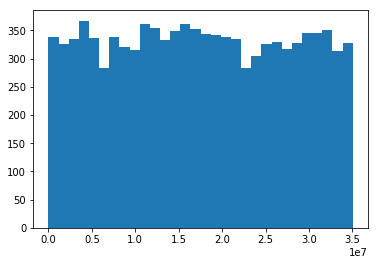

In [11]:
import matplotlib.pyplot as plt
plt.hist(shuffled_sample, bins=30);
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(valid_ids, bins=30)
plt.show()

In [12]:
# Getting the corresponding variants ids for shuffled sample
all_ids = load_pickle(all_ids_file)
all_ids.iloc[shuffled_sample].head()

17783505     1:49000062:A:['G']
7981343      8:98127146:T:['G']
33540028    12:47011284:N:['N']
9066941     10:25408052:A:['C']
1223325       2:5430769:G:['C']
dtype: object

In [13]:
ids_10k = all_ids.iloc[shuffled_sample]
ids_10k_file = training_dir + "ids_10k.pkl"
dump_to_pickle(ids_10k_file, ids_10k)

In [14]:
train_10k_file, valid_10k_file = (training_dir + "train_10k.pkl", training_dir + "valid_10k.pkl")
train_10k, valid_10k = train_test_split_indexes(ids_10k_file, 0.3, random_state=1)
dump_to_pickle(train_10k_file, train_10k)
dump_to_pickle(valid_10k_file, valid_10k)

In [15]:
train, valid = cadd_train_valid_data(lmdb_dir, train_10k_file, valid_10k_file)

In [17]:
vars_10k = CaddDataset(lmdb_dir, ids_10k_file)

In [20]:
%%time
X, y = vars_10k.load_all(num_workers=1, shuffle=False)
print(y.sum()/len(y), y.sum(), len(y))

ValueError: too many values to unpack (expected 2)

In [27]:
var_iter = vars_10k.batch_train_iter(batch_size=100, num_workers=10, shuffle=True)
ex = next(var_iter)
ex['targets'].sum()/len(ex['targets']), ex['targets'].sum(), len(ex['targets'])

(0.52, 52.0, 100)

In [17]:
train_10k_ds = CaddDataset(lmdb_dir, train_10k_file)
X, y = train_10k_ds.load_all(batch_size=64, num_workers=1, shuffle=False)
y.sum()/len(y), y.sum(), len(y)

(0.49257142857142855, 3448.0, 7000)

In [18]:
valid_10k_ds = CaddDataset(lmdb_dir, valid_10k_file)
X, y = valid_10k_ds.load_all(batch_size=64, num_workers=1, shuffle=False)
y.sum()/len(y), y.sum(), len(y)

(0.49266666666666664, 1478.0, 3000)

In [ ]:
valid_ds = CaddDataset(lmdb_dir, valid_id_file)
X, y = valid_ds.load_all(batch_size=64, num_workers=1, shuffle=False)
y.sum()/len(y), y.sum(), len(y)

I had to correct the CaddDataset.load_all function because it was giving me datasets with less than 0.5% possitive class. For some reason, I have to further investigate, batch_iter returns disorganized (or organized) examples. Probably it samples with replacement.